# How to work with (very large) Numpy Arrays in fastai2? Use Arrays On Disk!

Like some of you, I wanted to leverage the new fastai2 library for my time series projects. So I watched the walk-through videos and looked at the available course v3 notebooks re-written using fastai2.

In my case, I use numpy arrays as input in most cases. Those arrays are sometimes big enough that don't fit in memory. 
This is very common for example when using *semi-supervised/ self-supervised learning* that leverage large amounts of unlabeled data.

So I found 3 main issues to use fastai v2:

High level requirements
1. Numpy arrays don't always fit in memory.
2. Data is already split between X and y.
3. I need to be able to use Numpy Arrays as input.
4. I need to be able to work with unlabeled datasets

Let's see how I managed to overcome these issues.

In [1]:
#hide
from nbdev.showdoc import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
# from timeseries.core import *
from timeseries.models import *

## How to use Numpy Arrays in fastai v2?

So now, we just need 2 more things: 

* Very slightly modify Datasets so that we can use it with numpy arrays.
* In my case, since I use time series data, I also need to be able to plot them correctly.

In [ ]:
# # export
# @delegates(Datasets)
# class NumpyDatasets(FilteredBase):
#     "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
#     def __init__(self, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
#         super().__init__(dl_type=dl_type)
# #         self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
#         self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item, t in zip(items, L(ifnone(tfms,[None] * len(items))))])
#         self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

#     def __getitem__(self, it):
#         res = tuple([tl[it] for tl in self.tls])
#         return res if is_indexer(it) else list(zip(*res))

#     def __getattr__(self,k): return gather_attrs(self, k, 'tls')
#     def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
#     def __len__(self): return len(self.tls[0])
#     def __iter__(self): return (self[i] for i in range(len(self)))
#     def __repr__(self): return coll_repr(self)
#     def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
#     def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
#     def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
#     def overlapping_splits(self): return self.tls[0].overlapping_splits()
#     @property
#     def splits(self): return self.tls[0].splits
#     @property
#     def split_idx(self): return self.tls[0].tfms.split_idx
#     @property
#     def items(self): return self.tls[0].items
#     @items.setter
#     def items(self, v):
#         for tl in self.tls: tl.items = v

# #     def show(self, o, ctx=None, **kwargs):
# #         for o_,tl in zip(o, self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
# #         return ctx
    
#     def show(self, idx, figsize=None, **kwargs):
#         for i in idx if isinstance(idx, list) else [idx]: 
#             o = self.decode(self[i])
#             show_tuple(o, figsize=figsize,  **kwargs)

#     def new_empty(self):
#         tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
#         return type(self)(tls=tls, n_inp=self.n_inp)

#     @contextmanager
#     def set_split_idx(self, i):
#         old_split_idx = self.split_idx
#         for tl in self.tls: tl.tfms.split_idx = i
#         yield self
#         for tl in self.tls: tl.tfms.split_idx = old_split_idx

#     _docs=dict(
#         decode="Compose `decode` of all `tuple_tfms` then all `tfms` on `i`",
#         show="Show item `o` in `ctx`",
#         dataloaders="Get a `DataLoaders`",
#         overlapping_splits="All splits that are in more than one split",
#         subset="New `Datasets` that only includes subset `i`",
#         new_empty="Create a new empty version of the `self`, keeping only the transforms",
#         set_split_idx="Contextmanager to use the same `Datasets` with another `split_idx`"
#     )
    
# @delegates(plt.subplots)
# def show_tuple(tup, figsize=None, **kwargs):
#     "Display a timeseries plot from a tuple"
#     tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], figsize=figsize,  **kwargs)

In [ ]:
# class Datasets(FilteredBase):
#     "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
#     def __init__(self, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
#         super().__init__(dl_type=dl_type)
#         self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
#         self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

#     def __getitem__(self, it):
#         res = tuple([tl[it] for tl in self.tls])
#         return res if is_indexer(it) else list(zip(*res))

#     def __getattr__(self,k): return gather_attrs(self, k, 'tls')
#     def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
#     def __len__(self): return len(self.tls[0])
#     def __iter__(self): return (self[i] for i in range(len(self)))
#     def __repr__(self): return coll_repr(self)
#     def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
#     def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
#     def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
#     def overlapping_splits(self): return self.tls[0].overlapping_splits()
#     @property
#     def splits(self): return self.tls[0].splits
#     @property
#     def split_idx(self): return self.tls[0].tfms.split_idx
#     @property
#     def items(self): return self.tls[0].items
#     @items.setter
#     def items(self, v):
#         for tl in self.tls: tl.items = v

#     def show(self, o, ctx=None, **kwargs):
#         for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
#         return ctx

#     def new_empty(self):
#         tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
#         return type(self)(tls=tls, n_inp=self.n_inp)

#     @contextmanager
#     def set_split_idx(self, i):
#         old_split_idx = self.split_idx
#         for tl in self.tls: tl.tfms.split_idx = i
#         yield self
#         for tl in self.tls: tl.tfms.split_idx = old_split_idx

#     _docs=dict(
#         decode="Compose `decode` of all `tuple_tfms` then all `tfms` on `i`",
#         show="Show item `o` in `ctx`",
#         dataloaders="Get a `DataLoaders`",
#         overlapping_splits="All splits that are in more than one split",
#         subset="New `Datasets` that only includes subset `i`",
#         new_empty="Create a new empty version of the `self`, keeping only the transforms",
#         set_split_idx="Contextmanager to use the same `Datasets` with another `split_idx`"
#     )

In [153]:
# export
class TSTensor(TensorBase):

    @classmethod
    def create(cls, x): return cls(To2dplusTensor(x)) # creates a TSTensor with at least 2 dimensions

    @property
    def vars(self): return self.shape[-2]

    @property
    def len(self): return self.shape[-1]
    
    @property
    def items(self): return self.items

    def __repr__(self):
        if self.ndim == 2:   return f'TSTensor(vars={self.shape[0]}, len={self.shape[1]})'
        elif self.ndim > 2:  return f'TSTensor(samples={self.shape[-3]}, vars={self.shape[-2]}, len={self.shape[-1]})'

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToTSTensor(x):
    return TSTensor.create(x)

def TSTensorBlock(cls=TSTensor): return TransformBlock(type_tfms=cls.create)

In [83]:
# def show_title(o, ax=None, ctx=None, label=None, color='black', **kwargs):
#     "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
#     print('o:',o)
#     ax = ifnone(ax,ctx)
#     if ax is None: print(o)
#     elif hasattr(ax, 'set_title'):
#         t = ax.title.get_text()
#         if len(t) > 0: o = t+'\n'+str(o)
#         ax.set_title(o, color=color)
#     elif isinstance(ax, pd.Series):
#         while label in ax: label += '_'
#         ax = ax.append(pd.Series({label: o}))
#     return ax

# # Cell
# class ShowTitle:
#     "Base class that adds a simple `show`"
#     _show_args = {'label': 'text'}
#     def show(self, ctx=None, **kwargs):
#         "Show self"
#         return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

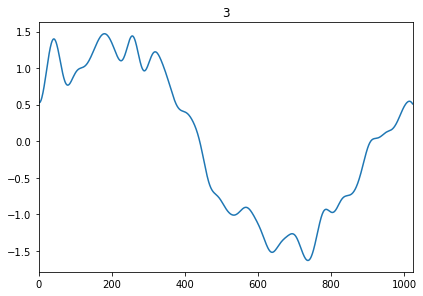

In [131]:
from fastai2.data.all import *
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   get_x=ItemGetter(0), get_y=ItemGetter(1), 
                   splitter=RandomSplitter()
                  )
dsets = dblock.datasets(L(X, y).zip())
t = dsets[0]
dsets.show(t);

In [132]:
dls = TfmdDL(dsets, bs=64)

In [133]:
t = dls.one_batch()
x,y = dls.decode_batch(t)[0]
x.shape,y

(torch.Size([1, 1024]), '3')

In [134]:
def cycle_dl(dl):
    for x,y in iter(dl):
        pass

In [135]:
cycle_dl(dls.valid)

In [137]:
%time cycle_dl(dls.valid)

CPU times: user 1.69 ms, sys: 924 µs, total: 2.62 ms
Wall time: 1.88 ms


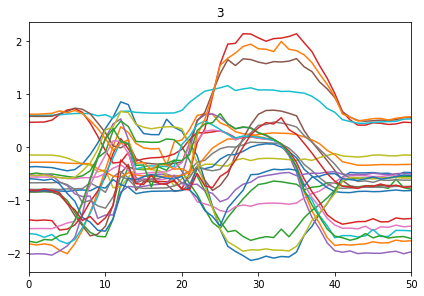

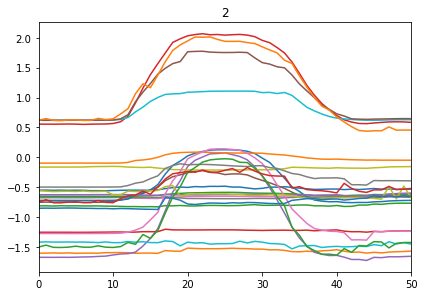

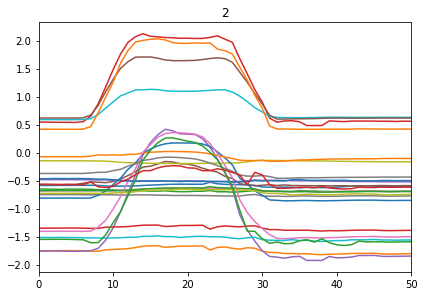

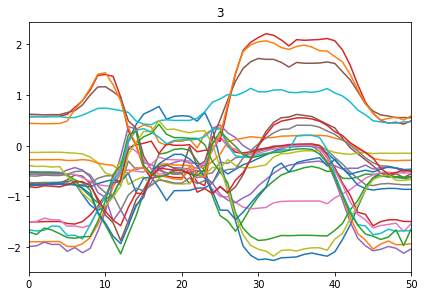

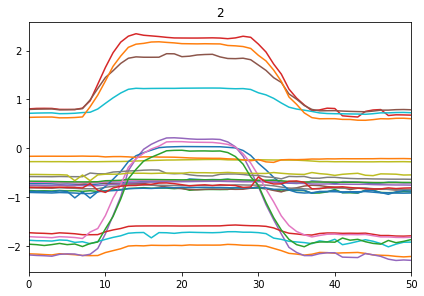

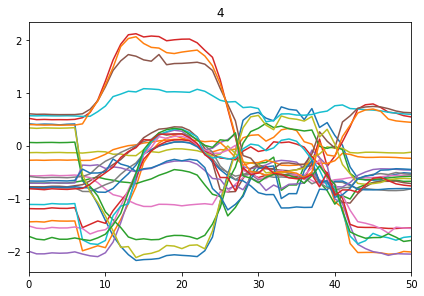

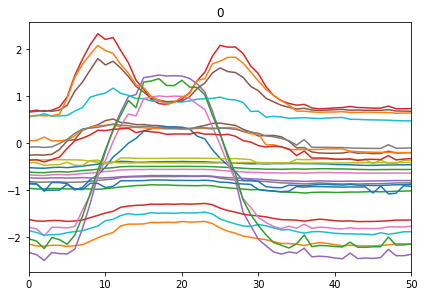

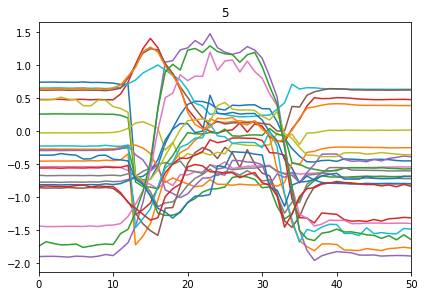

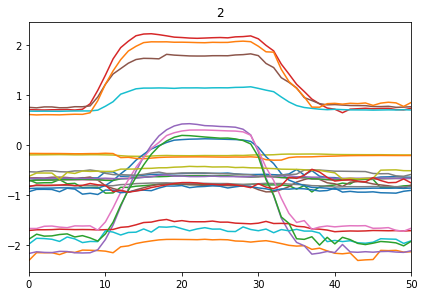

In [125]:
dls.show_batch()

In [39]:
# export
# class TSTuple(tuple):
    
#     @delegates(plt.subplots)
#     def show(self, ax=None, **kwargs):
#         if ax is None: fig, ax = plt.subplots(**kwargs)
#         ax.plot(self[0].T)
#         ax.axis(xmin=0, xmax=self[0].shape[-1] - 1)
#         ax.set_title('unlabeled' if len(self) == 1 else self[1], weight='bold')
#         if ax is None: 
#             plt.tight_layout()
#             plt.show()

In [ ]:
#export
# class TSDatasets(Datasets):
    
#     @delegates(plt.subplots)
#     def show(self, idx, **kwargs):
#         for i in idx if isinstance(idx, list) else [idx]: self.decode(self[i]).show(**kwargs)
#         plt.tight_layout()
#         plt.show()
    
#     def decode(self, o, full=True): return TSTuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))

In [149]:
#export
class TSTfmdDL(TfmdDL): 

    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, rows=None, cols=None, figsize=(10, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        sqrt = math.sqrt(len(db))
        if rows is None: rows = min(math.ceil(sqrt), len(db)) 
        if cols is None: cols = len(db) // rows
        fig, axs = plt.subplots(rows, cols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:rows ** 2], [axs] if rows == 1 else axs.flatten()): tup.show(ax=ax, **kwargs)
        plt.tight_layout()
        plt.show()

## Examples

### Datasets

I've used 2 datasets to test the enw functionality.

1. A large dataset that don't fit in memory (using np.memmap arrays)
2. A smaller dataset that fits in memory (using regular np.ndarrays)

As you can see, the only difference is really how you load the data:

1. To create a normal array load is with mmap_mode = None (default value). 
2. To create an array on disk (np.memmap) you'll need to select a mmap_mode. I normally use c, since I don't want to modify data on disk.

In [99]:
dsid = 'StarLightCurves'

In [102]:
if dsid == 'memmap':
    X = np.load('X_on_disk.npy', mmap_mode='c')
    y = np.load('y_on_disk.npy', mmap_mode='c')
    sel_arr_class = X.__class__.__name__

elif dsid == 'memmap_small':
    X = np.load('X_on_disk_small.npy', mmap_mode='c')
    y = np.load('y_on_disk_small.npy', mmap_mode='c')
    sel_arr_class = X.__class__.__name__

elif dsid == 'numeric':
    X = np.zeros((100, 5, 10)) + np.arange(100).reshape(100, 1, 1)
    y = np.arange(100)
    sel_arr_class = X.__class__.__name__
    
else:
    X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, path='..', verbose=False)
    X = np.concatenate((X_train, X_valid))
    y = np.concatenate((y_train, y_valid))
    folder = 'data/UCR'
    np.save(str(PATH.parent/f'{folder}/{dsid}/X.npy'), X) # cannot use pathlib.PosixPath as filename 
    np.save(str(PATH.parent/f'{folder}/{dsid}/y.npy'), y)
    del X, y
    X = np.load(str(PATH.parent/f'{folder}/{dsid}/X.npy'), mmap_mode='c')
    y = np.load(str(PATH.parent/f'{folder}/{dsid}/y.npy'), mmap_mode='c')
    sel_arr_class = X.__class__.__name__
    
X.shape, y.shape

((9236, 1, 1024), (9236,))

In [28]:
# class TSTransformBlock():
#     "A basic wrapper that links defaults transforms for the data block API"
#     def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
#         self.type_tfms  =            L(type_tfms)
#         self.item_tfms  = ToTensor + L(item_tfms)
#         self.batch_tfms =            L(batch_tfms)
#         self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
        
# def TSTensorBlock(cls=TSTensor): return TransformBlock(type_tfms=cls.create)

In [ ]:
items = L(X, y).zip()
items[:3]

In [ ]:
item = L(X, y).zip()[0]
item

In [ ]:
ToTSTensor(ItemGetter(0)(item))

In [14]:
get_items_from_numpy = itemify

In [69]:
from fastai2.data.all import *
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   get_x=ItemGetter(0), get_y=ItemGetter(1), 
                   splitter=RandomSplitter()
                  )
dsets = dblock.datasets(L(X, y).zip())
t = dsets[0]
dsets.show(t)

(#360) [(TSTensor(vars=24, len=51), TensorCategory(3)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(3)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(0)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(1))...]

In [70]:
t = dsets[0]
type(dsets.decode(t)[1])

fastai2.data.transforms.Category

ctx: None
3


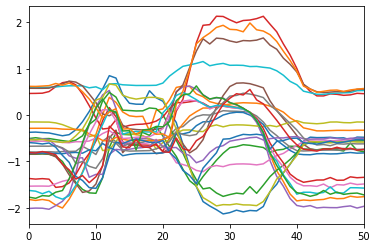

In [71]:
dsets.show(t)

In [33]:
dsets.train

(#288) [(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(0)),(TSTensor(vars=24, len=51), TensorCategory(1)),(TSTensor(vars=24, len=51), TensorCategory(1)),(TSTensor(vars=24, len=51), TensorCategory(5))...]

In [34]:
dsets.valid

(#72) [(TSTensor(vars=24, len=51), TensorCategory(3)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(1)),(TSTensor(vars=24, len=51), TensorCategory(3)),(TSTensor(vars=24, len=51), TensorCategory(5))...]

In [26]:
dsets.show(dsets.train[0])

TypeError: __init__() got an unexpected keyword argument 'ctx'

In [24]:
dls = dblock.dataloaders(dsets, )

KeyError: TensorCategory(3)

In [ ]:
from fastai2.data.all import *
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   get_items=itemify,
                   get_x=ItemGetter(0), get_y=ItemGetter(1), 
                   splitter=RandomSplitter()
                  )
dsets = dblock.datasets((X, y))
dsets.train[0]

In [28]:
dsets.decode(dsets.train[0])

(TSTensor(vars=24, len=51), '1')

In [23]:
dls = dblock.dataloaders(L(X, y).zip())
# dls.show_batch(rows=3, cols=3, sharey=True)

In [27]:
dls.dataset

(#288) [(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(0)),(TSTensor(vars=24, len=51), TensorCategory(3)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(4)),(TSTensor(vars=24, len=51), TensorCategory(5)),(TSTensor(vars=24, len=51), TensorCategory(3)),(TSTensor(vars=24, len=51), TensorCategory(1)),(TSTensor(vars=24, len=51), TensorCategory(2)),(TSTensor(vars=24, len=51), TensorCategory(5))...]

In [ ]:
tfms = [[ItemGetter(0), ToTSTensor], [ItemGetter(1), Categorize()]]
splits = RandomSplitter()(X)
items = L(X, y).zip()
dsets = Datasets(items, tfms=tfms, splits=splits)
t = dsets[0]
t

In [ ]:
t[0].data, t[1].data

In [ ]:
dsets.show(0)

### No tfms

In [ ]:
tfms = [[ItemGetter(0), ], [ItemGetter(1), ]]
splits = RandomSplitter()(X)
items = Lzip(X, y)
dsets = TSDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets[0], (X[0], y if y is None else y[0]))
test_eq(dsets[0][0].__class__.__name__, sel_arr_class)
dsets[0]

In [ ]:
# ALL DATA
tfms = [[ItemGetter(0), ], [ItemGetter(1), ]]
splits = RandomSplitter()(X)
items = Lzip(X, y)
dsets = TSDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets[0], (X[0], y if y is None else y[0]))
test_eq(dsets[0][0].__class__.__name__, sel_arr_class)
dsets[0]

In [ ]:
# TRAIN
tfms = [[ItemGetter(0), ], [ItemGetter(1), ]]
splits = RandomSplitter()(X)
items = Lzip(X, y)
dsets = TSDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets.train[0], (X[splits[0][0]], y if y is None else y[splits[0][0]]))
test_eq(dsets.train[0][0].__class__.__name__, sel_arr_class)
dsets.train[0]

In [ ]:
# VALID
tfms = [[ItemGetter(0), ], [ItemGetter(1), ]]
splits = RandomSplitter()(X)
items = Lzip(X, y)
dsets = TSDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets.valid[0], (X[splits[1][0]], y if y is None else y[splits[1][0]]))
test_eq(dsets.valid[0][0].__class__.__name__, sel_arr_class)
dsets.valid[0]

### Unlabeled

In [ ]:
# UNLABELED ALL
tfms = [[ItemGetter(0), ToTSTensor], []]
splits = RandomSplitter()(X)
items = Lzip(X,)
dsets = TSDatasets(items, tfms=tfms, splits=splits)
# test_eq(dsets[0], (X[0], ))
# test_eq(dsets[0][0].__class__.__name__, sel_arr_class)
dsets[0]

In [ ]:
# UNLABELED TRAIN
tfms = None
splits = RandomSplitter()(X)
items = tuple((samplify(X), ))
dsets = NumpyDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets.train[0], (X[splits[0][0]], ))
test_eq(dsets.train[0][0].__class__.__name__, sel_arr_class)
dsets.train[0]

In [ ]:
# UNLABELED VALID
tfms = None
splits = RandomSplitter()(X)
items = tuple((samplify(X), ))
dsets = NumpyDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets.valid[0], (X[splits[1][0]], ))
test_eq(dsets.valid[0][0].__class__.__name__, sel_arr_class)
dsets.valid[0]

### Transforms & decode

In [ ]:
# TFMS ALL
tfms = [[ToTSTensor], [Categorize()]]
splits = RandomSplitter()(X)
items = tuple((samplify(X), samplify(y)))
dsets = NumpyDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets[0][0].__class__.__name__, 'TSTensor')
test_eq(dsets[0][1].__class__.__name__, 'TensorCategory')
dsets[0], dsets[0][0].data, dsets[0][1].data

In [ ]:
# TFMS TRAIN
tfms = [[ToTSTensor], [Categorize()]]
splits = RandomSplitter()(X)
items = tuple((samplify(X), samplify(y)))
dsets = NumpyDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets.train[0][0].__class__.__name__, 'TSTensor')
test_eq(dsets.train[0][1].__class__.__name__, 'TensorCategory')
test_eq(dsets.decode(dsets.train[0])[0].data, tensor(X[splits[0][0]]))
test_eq(dsets.decode(dsets.train[0])[1], str(y[splits[0][0]]))
dsets.train[0], dsets.train[0][0].data, dsets.train[0][1].data, dsets.decode(dsets.train[0])

In [ ]:
# TFMS VALID
tfms = [[ToTSTensor], [Categorize(add_na=True)]]
splits = RandomSplitter()(X)
items = tuple((samplify(X), samplify(y)))
dsets = NumpyDatasets(items, tfms=tfms, splits=splits)
test_eq(dsets[0][0].__class__.__name__, 'TSTensor')
test_eq(dsets[0][1].__class__.__name__, 'TensorCategory')
if dsid != 'numeric': 
    test_eq(dsets.decode(dsets.valid[0])[0].data, tensor(X[splits[1][0]]))
    test_eq(dsets.decode(dsets.valid[0])[1], str(y[splits[1][0]]))
dsets.valid[0], dsets.valid[0][0].data, dsets.valid[0][1].data, dsets.decode(dsets.valid[0])

In [ ]:
# Decode
dec_x, dec_y = dsets.decode(dsets[0])
test_eq(dec_y, str(y[0]))
dsets[0], dec_x, dec_y, type(dec_x), type(dec_y)

### Plots

In [ ]:
tfms = [[ItemGetter(0), ToTSTensor], [ItemGetter(1), Categorize()]]
splits = RandomSplitter()(X)
items = Lzip(X, y)
dsets = TSDatasets(items, tfms=tfms, splits=splits)
dsets.show(idx=[0, 1])

In [ ]:
dsets.train.show(3)

In [ ]:
dsets.valid.show(idx=3)

### Dataloaders

In [156]:
tfms = [[ItemGetter(0), ToTSTensor], [ItemGetter(1), Categorize()]]
splits = RandomSplitter()(X)
items = itemify(X, y)
dsets = Datasets(items, tfms=tfms, splits=splits)
dls = TSTfmdDL(dsets, bs=16)
xb,yb = dls.one_batch()
(xb, yb), (xb[0], yb[0]), dls.decode_batch((xb, yb))[0]

IndexError: list index out of range

In [ ]:
train_dl = TSTfmdDL(dsets.train, bs=16)
xb,yb = train_dl.one_batch()
if dsid == 'numeric': test_eq(train_dl.decode_batch((xb, yb))[0][1], str(y[splits[0][0]]))
(xb[0], yb[0]), train_dl.decode_batch((xb, yb))[0]

In [ ]:
valid_dl = TSTfmdDL(dsets.valid, bs=16)
xb,yb = valid_dl.one_batch()
(xb[0], yb[0]), valid_dl.decode_batch((xb, yb))[0]

In [ ]:
dls.show_batch(max_n=9, figsize=(10,10), sharey=True)

In [ ]:
train_dl.show_batch(max_n=9, figsize=(10, 10))

In [ ]:
valid_dl.show_batch(max_n=9, figsize=(10, 10), sharey=True)

## Learner

In [139]:
import torch
import torch.nn as nn
from fastai2.torch_core import *
from fastai2.layers import *
from fastai2.imports import *

# Iception Time paper: https://arxiv.org/abs/1909.04939

class AdaptiveConcatPool1d(nn.Module):
    "Layer that concats `AdaptiveAvgPool1d` and `AdaptiveMaxPool1d`"
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool1d(self.size)
        self.mp = nn.AdaptiveMaxPool1d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


act_fn = nn.ReLU(inplace=True)
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

class Shortcut(Module):
    "Merge a shortcut with the result of the module by adding them. Adds Conv, BN and ReLU"
    def __init__(self, ni, nf, act_fn=act_fn): 
        self.act_fn=act_fn
        self.conv=conv(ni, nf, 1)
        self.bn=nn.BatchNorm1d(nf)
    def forward(self, x): return act_fn(x + self.bn(self.conv(x.orig)))

class InceptionModule(Module):
    def __init__(self, ni, nb_filters=32, kss=[39, 19, 9], bottleneck_size=32, stride=1):
        self.bottleneck = nn.Conv1d(ni, bottleneck_size, 1) if (bottleneck_size>0 and ni>1) else noop
        self.convs = nn.ModuleList([conv(bottleneck_size if (bottleneck_size>1 and ni>1) else ni, nb_filters, ks) for ks in kss])
        self.maxpool_bottleneck = nn.Sequential(nn.MaxPool1d(3, stride, padding=1), conv(ni, nb_filters, 1))
        self.bn_relu = nn.Sequential(nn.BatchNorm1d((len(kss)+1)*nb_filters), nn.ReLU())
    def forward(self, x):
        bottled = self.bottleneck(x)
        return self.bn_relu(torch.cat([c(bottled) for c in self.convs]+[self.maxpool_bottleneck(x)], dim=1))

def inception_time(ni, nout, ks=40, depth=6, bottleneck_size=32, nb_filters=32, head=True):
    layers = []
    
    # compute kernel sizes: eg for ks=40 => kss=[39, 19, 9] 
    kss = [ks // (2**i) for i in range(3)]
    # ensure odd kss until nn.Conv1d with padding='same' is available in pytorch 1.3
    kss = [ksi if ksi % 2 != 0 else ksi - 1 for ksi in kss]
    n_ks = len(kss) + 1
    for d in range(depth):
        # Farid
      # im = SequentialEx(InceptionModule(ni if d==0 else n_ks*nb_filters, kss=kss, bottleneck_size=bottleneck_size))
        im = SequentialEx(InceptionModule(ni if d==0 else n_ks*nb_filters, kss=kss, bottleneck_size=bottleneck_size if d > 0 else 0))
        if d%3==2: im.append(Shortcut(n_ks*nb_filters, n_ks*nb_filters))      
        layers.append(im)
    head = [AdaptiveConcatPool1d(), Flatten(), nn.Linear(2*n_ks*nb_filters, nout)] if head else []
    return  nn.Sequential(*layers, *head)

In [ ]:
tfms =   [[ItemGetter(0), ToTSTensor], [ItemGetter(1), Categorize()]]
splits = RandomSplitter()(X)
items =  Lzip(X,y)
dsets =  TSDatasets(items, tfms=tfms, splits=splits)
dls =    TSTfmdDL(dsets, bs=16)
model =  ResNet(dls.vars, dls.c)
# model  = inception_time(dls.vars, dls.c)
learn =  Learner(dls.dataloaders(),
                model,
                loss_func=nn.CrossEntropyLoss(),
                metrics=accuracy,
#                 cbs=VerboseCallback()
               )

In [ ]:
train_dl, valid_dl = dls.dataloaders()
train_ds, valid_ds = dls.train, dls.valid

In [ ]:
dls.show_batch()

In [ ]:
xb,yb=dls.one_batch()
learn.loss_func(model(xb), yb)

In [ ]:
from fastai2.callback.all import *
learn.fit_one_cycle(25, lr_max=1e-3)

In [ ]:
# delegates(Learner.__init__)


# # def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
# # y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
# def ts_learner(dls,
#                model=None,
#                #opt_func=Ranger,
#                loss_func=None,
#                cbs=None,
#                metrics=None,
#                **kwargs):
#     "Build a ts learner with default settings if None is passed"
#     n_in = dls.vars #get_n_channels(dls.train)  # data.n_channels
#     n_out = dls.c  # Number of classes

#     if model is None:
#         model = inception_time(n_in, n_out).to(device=default_device())
#     #     if opt_func is None: opt_func = Ranger
#     if loss_func is None: loss_func = LabelSmoothingCrossEntropy()
#     if cbs is None: cbs = L(cbs)
#     if metrics is None: metrics = accuracy

#     learn = Learner(dls,
#                     model,
#                     #opt_func=opt_func,
#                     loss_func=loss_func,
# #                     metrics=metrics,
# #                     **kwargs
#                    )

#     return learn

In [150]:
from fastai2.data.all import *
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   get_x=ItemGetter(0), get_y=ItemGetter(1), 
                   splitter=RandomSplitter()
                  )
dsets = dblock.datasets(itemify(X,y))
dls =    TSTfmdDL(dsets, bs=16)
# model =  ResNet(dls.vars, dls.c)
model  = inception_time(dls.vars, dls.c)
learn =  Learner(dls.dataloaders(),
                model,
                loss_func=nn.CrossEntropyLoss(),
                metrics=accuracy,
#                 cbs=VerboseCallback()
               )

AttributeError: 'tuple' object has no attribute 'show'

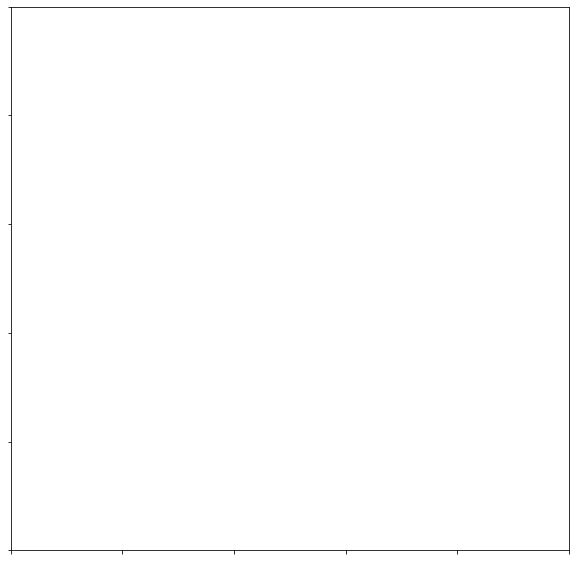

In [151]:
dls.show_batch()

In [147]:
from fastai2.callback.all import *
learn.fit_one_cycle(25, lr_max=1e-3)

(#5) [0,nan,None,None,'00:00']
(#3) [1,nan,'00:00']


RuntimeError: DataLoader worker (pid 40107) is killed by signal: Unknown signal: 0. 

NameError: name 'TensorBlock' is not defined